In [142]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.special import gamma
from scipy.optimize import curve_fit
from joblib import Parallel, delayed

# ----------------------------------------------------------------
# 1. Basic functions (Poisson point generation, max SNR calculation, approximated model, etc.)
# ----------------------------------------------------------------

def generate_hppp(lambda_intensity, space_range):
    """Generate points from a 2D homogeneous Poisson point process (HPPP)."""
    area = space_range**2
    num_points = np.random.poisson(lambda_intensity * area)

    x_coords = np.random.uniform(-space_range/2, space_range/2, num_points)
    y_coords = np.random.uniform(-space_range/2, space_range/2, num_points)
    return np.column_stack((x_coords, y_coords))

def calculate_max_eavesdropper_snr(eavesdropper_density, space_range, alpha):
    """ Evaluate the maximum SNR of randomly placed eavesdroppers in a single experiment (sample). """
    points = generate_hppp(eavesdropper_density, space_range)
    if len(points) == 0:
        return 0.0
    distances = np.linalg.norm(points, axis=1)
    # 도청자 채널 g ~ Exponential(1), 경로손실 d^-α
    snrs = np.random.exponential(scale=1.0, size=len(distances)) / distances**alpha
    return np.max(snrs)

def approximated_SPSC_prob(kappa, distance, a=1.0, p=1.0):
    """
        SPSC ≈ exp(- a * (kappa^p) * distance^2).
    """
    return np.exp(- a * kappa**p * distance**2)

def fit_power_kappa_density(kappa_array, spsc_array, distance):
    """
    Estimate (a, p) by curve_fit:
      min_{a,p} Σ [ spsc_i - exp(- a*(kappa_i^p)*distance^2 ) ]^2
    """
    popt, _ = curve_fit(
        lambda xdata, a, p: approximated_SPSC_prob(xdata, distance, a, p),
        kappa_array, 
        spsc_array,
        p0=[1.0, 1.0],
        bounds=([0, 0], [np.inf, np.inf])
    )
    return popt[0], popt[1]

def fit_power_kappa_distance(kappa, spsc_array, distance_array):
    """
    Estimate (a, p) by curve_fit:
      min_{a,p} Σ [ spsc_i - exp(- a*(kappa_i^p)*distance^2 ) ]^2
    """
    popt, _ = curve_fit(
        lambda xdata, a, p: approximated_SPSC_prob(kappa, xdata, a, p),
        distance_array, 
        spsc_array,
        p0=[1.0, 1.0],
        bounds=([0, 0], [np.inf, np.inf])
    )
    return popt[0], popt[1]

def single_experiment(eavesdropper_density, space_range, alpha, legit_distance, jamming_gain=1):
    """
    Single experiment for parallel processing.
    """
    max_eve_snr = calculate_max_eavesdropper_snr(eavesdropper_density, space_range, alpha)
    legit_snr = np.random.exponential(scale=1.0) / (legit_distance**alpha)
    return int(jamming_gain * legit_snr > max_eve_snr)

# ----------------------------------------------------------------
# 2. Utils for network simulation
# ----------------------------------------------------------------

def dbm_to_mw(dbm):
    return 10 ** (dbm / 10)

def mw_to_dbm(mw):
    return 10 * np.log10(mw)

def required_jamming_power(SPSC_threshold, distance, kappa, alpha, bandwidth):
    """
    Equation (30) in the paper.
    """
    base = kappa * distance ** 2 / np.log(1 / SPSC_threshold)
    nyquist_noise = dbm_to_mw(-174 + 10 * np.log10(bandwidth*10**6))
    return (base ** (alpha / 2) -1) * nyquist_noise

def jamming_power_to_gain(jamming_dbm, bandwidth=250):
    power = dbm_to_mw(jamming_dbm)
    nyquist_noise = dbm_to_mw(-174 + 10 * np.log10(bandwidth*10**6))
    return 1 + power / nyquist_noise

# ----------------------------------------------------------------
# 2. Parallel Monte-Carlo simulation for SPSC vs. density
# ----------------------------------------------------------------

def simulate_spsc_vs_density_parallel(density_list, space_range, alpha, legit_distance, num_experiment=10000, n_jobs=-1, verbose=True):
    """
    Compute SPSC probability for multiple eavesdropper densities in parallel.

    Returns:
      kappa_array, spsc_array
    """
    kappa_list = []
    spsc_list = []

    for idx, eavesdropper_density in enumerate(density_list):
        kappa = (np.pi * eavesdropper_density
                 / np.sin(np.pi * 2 / alpha))
        kappa_list.append(kappa)

        # Repeat the experiment for num_experiment times
        results = Parallel(n_jobs=n_jobs)(
            delayed(single_experiment)(eavesdropper_density, space_range, alpha, legit_distance)
            for _ in range(num_experiment)
        )
        spsc_est = np.mean(results)
        spsc_list.append(spsc_est)

        if verbose:
            print(f"{idx} | density={eavesdropper_density:.2e}, SPSC={spsc_est:.4f}")

    return np.array(kappa_list), np.array(spsc_list)

def simulate_spsc_vs_distance_parallel(distance_list, space_range, alpha, density, num_experiment=10000, n_jobs=-1, verbose=True):
    """
    Compute SPSC probability for multiple distances in parallel.

    Returns:
      distance_array, spsc_array
    """
    spsc_list = []

    for idx, legit_distance in enumerate(distance_list):
        # Repeat the experiment for num_experiment times
        results = Parallel(n_jobs=n_jobs)(
            delayed(single_experiment)(density, space_range, alpha, legit_distance)
            for _ in range(num_experiment)
        )
        spsc_est = np.mean(results)
        spsc_list.append(spsc_est)

        if verbose:
            print(f"{idx} | distance={legit_distance:.2f}, SPSC={spsc_est:.4f}")

    return np.array(spsc_list)

def simulate_jamming_power_vs_distance_parallel(
        distance_list, space_range, alpha, density, spsc_threshold, bandwidth,
        num_experiment=10000, n_jobs=-1, verbose=True
    ):
    """
    Compute SPSC probability for multiple distances in parallel.

    Returns:
      distance_array, spsc_array
    """
    jamming_power_list = []

    for idx, legit_distance in enumerate(distance_list):
        # Bisection method to find the minimum jamming power
        count = 0
        lower = - 100
        upper = 30
        while upper - lower > 0.1:
            jamming_power = (lower + upper) / 2
            jamming_gain = jamming_power_to_gain(jamming_power, bandwidth)
            # Parallel Monte-Carlo simulation
            results = Parallel(n_jobs=n_jobs)(
                delayed(single_experiment)(density, space_range, alpha, legit_distance, jamming_gain)
                for _ in range(num_experiment)
            )
            spsc_est = np.mean(results)
            if spsc_est > spsc_threshold:
                upper = jamming_power
            else:
                lower = jamming_power
            count += 1
        print(f"{idx} | distance={legit_distance:.2f}, jamming_power={jamming_power:.2f}, SPSC={spsc_est:.4f}, count={count}")
        jamming_power_list.append(jamming_power)
    return np.array(jamming_power_list)

# SPSC Probability vs Eavesdropper density

In [2]:
# (A) Environment setup
alpha = 3.0  # pathloss exponent
space_range = 5000
num_experiment = 50000
density_list = np.logspace(-9, -3, 40)  # log-scale eavesdropper density
distance_array = np.array([50, 100, 200, 400])  # legitimate distance

all_results = {}

# (B) Simulation for each distance
for legit_distance in distance_array:
    print(f"Starting simulation for distance={legit_distance:.1f}...")
    kappa_array, spsc_array = simulate_spsc_vs_density_parallel(
        density_list, space_range, alpha, legit_distance,
        num_experiment=num_experiment, n_jobs=-1, verbose=False
    )

    # fitting the approximated model
    a_opt, p_opt = fit_power_kappa_density(kappa_array, spsc_array, legit_distance)
    approx_spsc_array = approximated_SPSC_prob(kappa_array, legit_distance, a_opt, p_opt)
    print(f"fitted parameters for distance={legit_distance:.1f}: a={a_opt:.4f}, p={p_opt:.4f}\n")
    
    # Save the results
    all_results[legit_distance] = {
        "kappa_array": kappa_array,
        "spsc_array": spsc_array,
        "approx_spsc_array": approx_spsc_array,
        "a_opt": a_opt,
        "p_opt": p_opt,
    }

Starting simulation for distance=50.0...
fitted parameters for distance=50.0: a=0.2256, p=0.8063

Starting simulation for distance=100.0...
fitted parameters for distance=100.0: a=0.1753, p=0.8077

Starting simulation for distance=200.0...
fitted parameters for distance=200.0: a=0.1319, p=0.8063

Starting simulation for distance=400.0...
fitted parameters for distance=400.0: a=0.1004, p=0.8061



The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


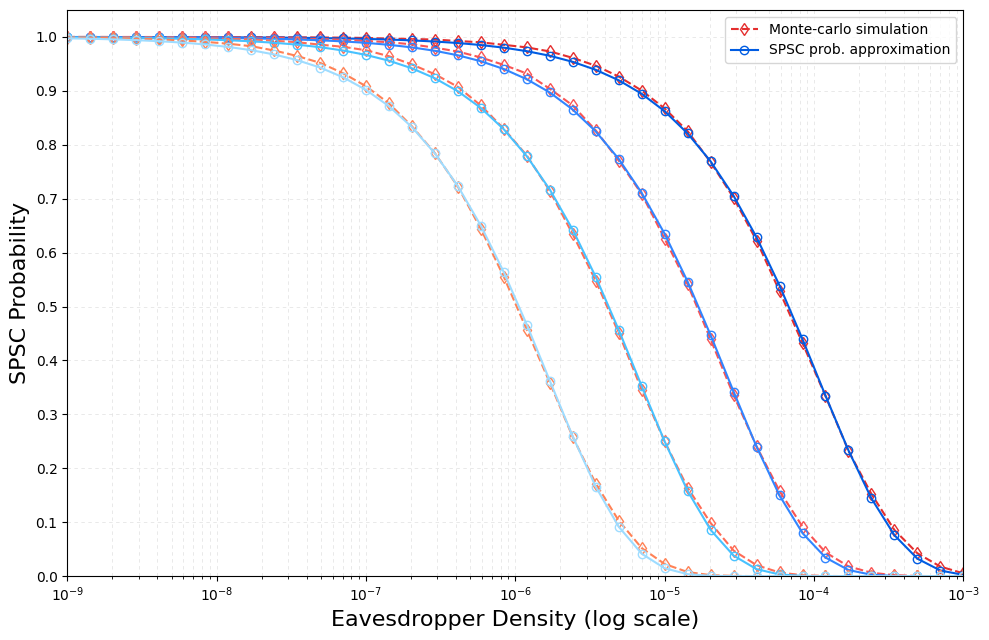

In [ ]:
colors_red = np.array([
[228, 46, 46],
[249, 84, 84],
[255, 108, 86],
[255, 130, 86],
]) / 255.
colors_blue = np.array([
[0, 92, 226],
[49, 133, 255],
[72, 194, 255],
[158, 220, 255],
]) / 255.

fontsize = 16
font = 'pretendard'

# (C) Plot the results
plt.figure(figsize=(10, 6.5))
for i, (legit_distance, results) in enumerate(all_results.items()):
    plt.plot(density_list,
             results["spsc_array"],
             label=f"Monte-carlo simulation" if i == 0 else None,
             marker='d',
             markerfacecolor='none',
             color=colors_red[i],
             linestyle='--', 
             )
    plt.plot(density_list, 
             results["approx_spsc_array"],
             label=f"SPSC prob. approximation" if i == 0 else None,
             marker='o', 
             markerfacecolor='none',
             color=colors_blue[i],)

plt.xscale('log')
plt.xlabel('Eavesdropper Density (log scale)', fontsize=fontsize)
plt.ylabel('SPSC Probability', fontsize=fontsize)
plt.ylim(0, 1.05)
plt.xlim(density_list[0], density_list[-1])
plt.yticks(np.arange(0, 1.1, 0.1))
plt.legend(fontsize=10)
plt.grid(True, which='both', linestyle=(0, (5, 5)), linewidth=0.5, color="#e0e0e0")
plt.tight_layout()
plt.savefig("spsc_vs_density.eps", format='eps', dpi=1000)
plt.show()

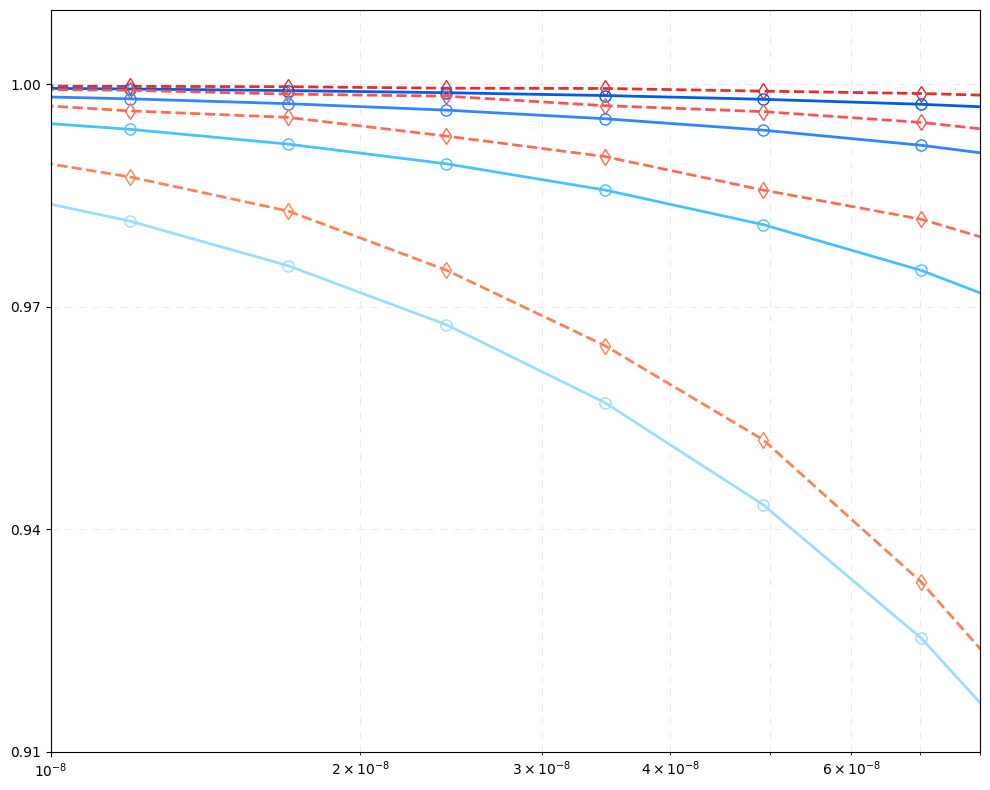

In [51]:
# (C-1, Optional) Plot the magnified results with limited density range.
plt.figure(figsize=(10, 8))
for i, (legit_distance, results) in enumerate(all_results.items()):
    plt.plot(density_list,
             results["spsc_array"],
             label=f"Simulation (distance={legit_distance:.0f})",
             marker='d',
             markerfacecolor='none',
             markersize=8,
             color=colors_red[i],
             linestyle='--', 
             linewidth=2.0,
             )
    plt.plot(density_list, 
             results["approx_spsc_array"],
             label=f"Approximation (distance={legit_distance:.0f})",
             marker='o', 
             markerfacecolor='none',
             markersize=8,
             color=colors_blue[i],
             linewidth=2.0,
             )

# from matplotlib.ticker import MultipleLocator
plt.xscale('log')
plt.ylim(0.91, 1.01)
plt.xlim(1e-8, 8e-8)
plt.yticks(np.arange(0.91, 1.01, 0.03))
plt.grid(True, which='both', linestyle=(0, (10, 10)), linewidth=0.5, color="#e0e0e0")
plt.tight_layout()
plt.savefig("spsc_vs_density_mag.eps", format='eps', dpi=1000)
plt.show()

# SPSC Probability vs Link distance

In [ ]:
# (A) Environment setup
alpha = 3.0  # pathloss exponent
space_range = 5000
num_experiment = 50000
density_list = [1e-7, 1e-6, 1e-5, 1e-4]  # eavesdropper density
distance_array = np.linspace(40, 1000, 40)  # legitimate distance

all_results_distance = {}

# (B) Simulation for each legitimate distance
for density in density_list:
    print(f"Starting simulation for {density=:.2e}...")
    kappa = (np.pi * density 
                / np.sin(np.pi * 2 / alpha))
    # Perform simulation (assumes implementation of simulate_spsc_vs_density_parallel)
    spsc_array = simulate_spsc_vs_distance_parallel(
        distance_array, space_range, alpha, density,
        num_experiment=num_experiment, n_jobs=-1, verbose=False
    )

    # Fit the approximated model (assumes implementation of fit_power_kappa)
    a_opt, p_opt = fit_power_kappa_distance(kappa, spsc_array, distance_array)
    # Compute approximated SPSC probability (assumes implementation of approximated_SPSC_prob)
    approx_spsc_array = approximated_SPSC_prob(kappa, distance_array, a_opt, p_opt)
    print(f"Fitted parameters for {density=:.2e}: a={a_opt:.4f}, p={p_opt:.4f}\n")
    
    # Save simulation and fitted results
    all_results_distance[density] = {
        "distance_array": distance_array,
        "spsc_array": spsc_array,
        "approx_spsc_array": approx_spsc_array,
        "a_opt": a_opt,
        "p_opt": p_opt,
    }

Starting simulation for density=1.00e-07...
Fitted parameters for density=1.00e-07: a=1.3571, p=1.0001

Starting simulation for density=1.00e-06...
Fitted parameters for density=1.00e-06: a=1.0428, p=1.0006

Starting simulation for density=1.00e-05...
Fitted parameters for density=1.00e-05: a=1.0277, p=1.0006

Starting simulation for density=1.00e-04...
Fitted parameters for density=1.00e-04: a=1.0093, p=1.0002



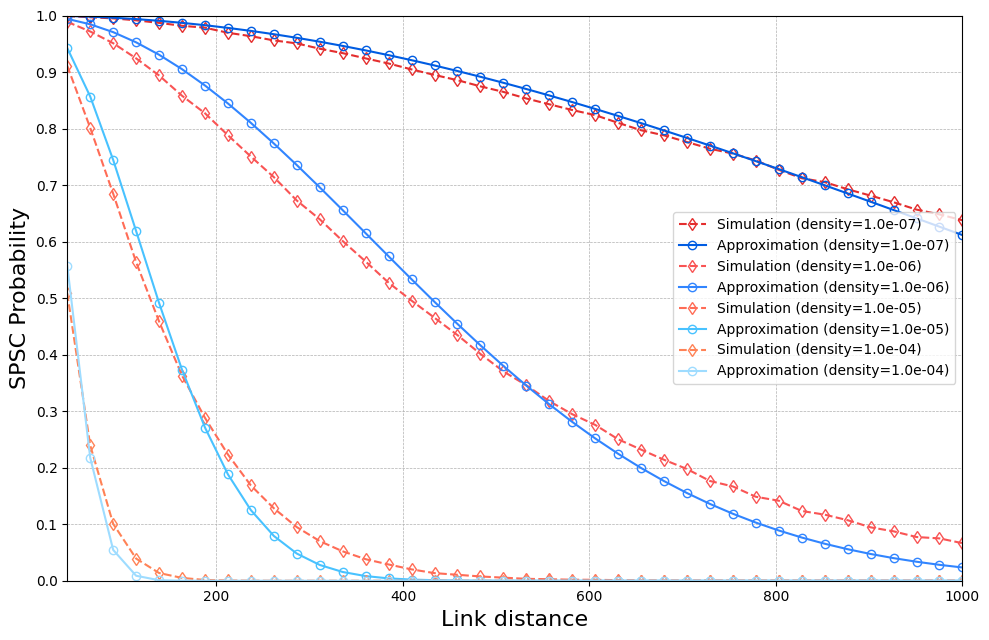

In [75]:
colors_red = np.array([
[228, 46, 46],
[249, 84, 84],
[255, 108, 86],
[255, 130, 86],
]) / 255.
colors_blue = np.array([
[0, 92, 226],
[49, 133, 255],
[72, 194, 255],
[158, 220, 255],
]) / 255.

fontsize = 16
font = 'arial'

# (C) Plot the results
plt.figure(figsize=(10, 6.5))
for i, (density, results) in enumerate(all_results_distance.items()):
    if i==4:
        break
    plt.plot(distance_array,
             results["spsc_array"],
             label=f"Simulation (density={density:.1e})",
             marker='d',
             markerfacecolor='none',
             color=colors_red[i],
             linestyle='--', 
             )
    plt.plot(distance_array, 
             results["approx_spsc_array"],
             label=f"Approximation (density={density:.1e})",
             marker='o', 
             markerfacecolor='none',
             color=colors_blue[i],)

plt.xlabel('Link distance', fontsize=fontsize)
plt.ylabel('SPSC Probability', fontsize=fontsize)
plt.ylim(0, 1)
plt.xlim(distance_array[0], distance_array[-1])
plt.yticks(np.arange(0, 1.1, 0.1))
plt.legend(fontsize=10)
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.tight_layout()
plt.show()

# Jamming power vs. distance 

In [ ]:
# (A) Environment setup
alpha = 3.0  # pathloss exponent
spsc_prob_threshold = 0.999
bandwidth = 250
space_range = 5000
num_experiment = 50000
density_list = [1e-5, 1e-4, 1e-3]  # eavesdropper density
distance_array = np.linspace(40, 1000, 40)  # legitimate distance

all_results_jamming = {}

# (B) Simulation for each legitimate distance
for density in density_list:
    print(f"Starting simulation for {density=:.2e}...")
    kappa = (np.pi * density 
                / np.sin(np.pi * 2 / alpha))

    jamming_power_approx = mw_to_dbm(required_jamming_power(spsc_prob_threshold, distance_array, kappa, alpha, bandwidth))
    print(f"required_jamming_power={jamming_power_approx} dBm")
    # Perform simulation (assumes implementation of simulate_spsc_vs_distance_parallel)
    jamming_power_array = simulate_jamming_power_vs_distance_parallel(
        distance_array, space_range, alpha, density,
        spsc_prob_threshold, bandwidth, num_experiment=num_experiment, n_jobs=-1, verbose=False
    ) 

    # Save simulation and fitted results
    all_results_jamming[density] = {
        "distance_array": distance_array,
        "jamming_power_array": jamming_power_array,
        "required_jamming_power": required_jamming_power(spsc_prob_threshold, distance_array, kappa, alpha, bandwidth),
    }

Starting simulation for density=1.00e-05...
required_jamming_power=[4.38772087e-07 1.85275324e-06 4.88088276e-06 1.01380743e-05
 1.82392415e-05 2.97992981e-05 4.54331577e-05 6.57557339e-05
 9.13819405e-05 1.22926691e-04 1.61004899e-04 2.06231479e-04
 2.59221343e-04 3.20589407e-04 3.90950582e-04 4.70919783e-04
 5.61111924e-04 6.62141919e-04 7.74624680e-04 8.99175122e-04
 1.03640816e-03 1.18693870e-03 1.35138167e-03 1.53035197e-03
 1.72446452e-03 1.93433423e-03 2.16057602e-03 2.40380480e-03
 2.66463548e-03 2.94368298e-03 3.24156221e-03 3.55888809e-03
 3.89627552e-03 4.25433942e-03 4.63369471e-03 5.03495630e-03
 5.45873911e-03 5.90565803e-03 6.37632800e-03 6.87136393e-03]
0 | distance=40.00, jamming_power=-59.18, SPSC=0.9988, count=11
1 | distance=64.62, jamming_power=-52.58, SPSC=0.9989, count=11
2 | distance=89.23, jamming_power=-47.76, SPSC=0.9991, count=11
3 | distance=113.85, jamming_power=-45.85, SPSC=0.9989, count=11
4 | distance=138.46, jamming_power=-42.93, SPSC=0.9990, count=11


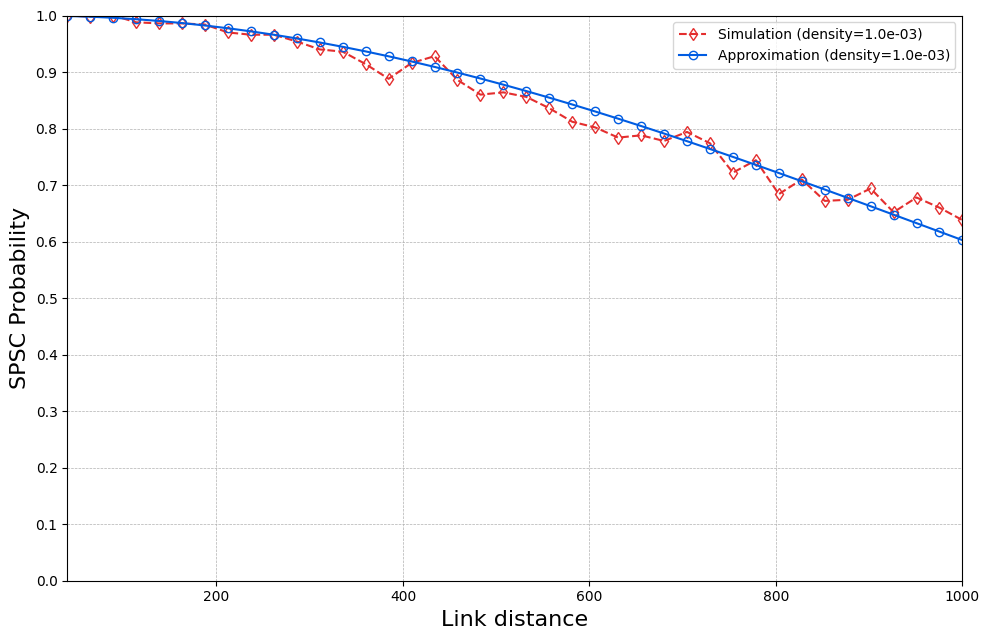

In [96]:
colors_red = np.array([
[228, 46, 46],
[249, 84, 84],
[255, 108, 86],
[255, 130, 86],
]) / 255.
colors_blue = np.array([
[0, 92, 226],
[49, 133, 255],
[72, 194, 255],
[158, 220, 255],
]) / 255.

fontsize = 16
font = 'arial'

# (C) Plot the results
plt.figure(figsize=(10, 6.5))
for i, (density, results) in enumerate(all_results_distance.items()):
    if i==4:
        break
    plt.plot(distance_array,
             results["spsc_array"],
             label=f"Simulation (density={density:.1e})",
             marker='d',
             markerfacecolor='none',
             color=colors_red[i],
             linestyle='--', 
             )
    plt.plot(distance_array, 
             results["approx_spsc_array"],
             label=f"Approximation (density={density:.1e})",
             marker='o', 
             markerfacecolor='none',
             color=colors_blue[i],)

plt.xlabel('Link distance', fontsize=fontsize)
plt.ylabel('SPSC Probability', fontsize=fontsize)
plt.ylim(0, 1)
plt.xlim(distance_array[0], distance_array[-1])
plt.yticks(np.arange(0, 1.1, 0.1))
plt.legend(fontsize=10)
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.tight_layout()
plt.show()